The cell below imports all the required libraries and defines key variables. You'll have to run cells one at a time from top to bottom. If you run them out of order, things won't work.

This notebook will closely follow the tutorial here - https://docs.lightkurve.org/tutorials/1-getting-started/what-are-lightcurve-objects.html.

In [2]:
# Make plots in the notebook so you can see them.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation as mad
from scipy.integrate import quad

import lightkurve # Import the lightkurve library
from lightkurve import search_targetpixelfile # From the lightkurve library, import the search_targetpixelfile method.

In [105]:
# Give your planet name - be sure to spell everything exactly right. Otherwise, the package won't find the data.
planet_name = "XO-1"

# Open a Target Pixel File from MAST and download one data file.
tpf = search_targetpixelfile(planet_name).download()

# Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).remove_nans()
print(lc) # You should see a table of data below that looks like (but not exactly like) the pasted text below.
#  time            flux          flux_err     ... cadenceno quality
#                    electron / s    electron / s   ...                  
# ------------------ ------------ ----------------- ... --------- -------
# 120.52924274596444 401333.15625 91.52275085449219 ...      5500       0

       time              flux           flux_err      ... cadenceno quality
                     electron / s     electron / s    ...                  
------------------ --------------- ------------------ ... --------- -------
1955.7990267537568 9087.6220703125  12.76364517211914 ...    524405       0
1955.8004156718298    9094.9296875 12.802447319030762 ...    524406       0
1955.8018045901358 9065.2783203125 12.754873275756836 ...    524407       0
 1955.803193508209  9066.900390625   12.7570161819458 ...    524408       0
 1955.804582426282 9066.4423828125 12.756695747375488 ...    524409       0
 1955.805971344355 9077.1083984375 12.761527061462402 ...    524410       0
1955.8073602624281 9076.0576171875  12.75792407989502 ...    524411       0
1955.8087491805013  9069.658203125 12.750633239746094 ...    524412       0
1955.8101380985736   9066.41015625  12.78093147277832 ...    524413       0
1955.8115270166459 9081.2880859375 12.797823905944824 ...    524414       0
            

/Users/brian/opt/anaconda3/envs/PHYS305_Observing_Project/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Let's start by plotting your data. As a general rule, you should always inspect any data you intend to use and do NOT just assume the data are fine.

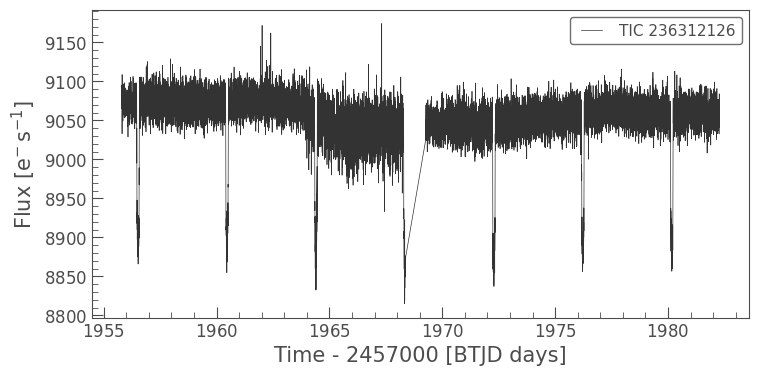

In [106]:
lc.plot();

Hopefully, what you see above is a series of transit dips, probably with some scatter. 

In some cases, you may also see individual points with excursions unassociated with the transit dips, which we'll call "single-point outliers". 

There may also be some up-and-down wobbles unassocated with the transit dips. We'll call these signals "systematic noise".

In order to conduct our transit analysis, we will need to remove as much of those sources of noise as possible. 

---

### Removing Single-Point Outliers

Since the single-point outliers are big, discrete jumps, we can try to find them by using the technique we talked about in class before: calculating the derivative of the time-series and then looking for big outlier values.

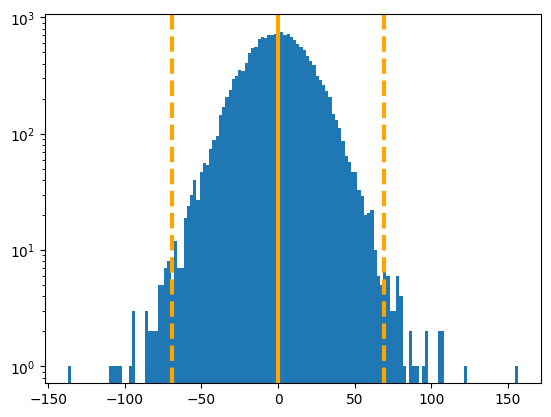

In [107]:
# Calculate the derivative
df = np.diff(lc['flux']).value
num_sigma = 5.

# Calculate the median value
med = np.median(df)
# Calculate the standard deviation
std = mad(df)

# Make a histogram showing the distribution of derivative values.
plt.hist(df, bins='auto');
plt.yscale('log') # Make it easier to the outliers

# Add in lines showing the expected width of the distribution if it were just Gaussian.
plt.axvline(med, lw=3, color='orange')
plt.axvline(med - num_sigma*std, lw=3, color='orange', ls='--')
plt.axvline(med + num_sigma*std, lw=3, color='orange', ls='--')

Remember that we often approximate the noise in a dataset as a Gaussian distribution. That means we can *assume* a Gaussian distribution and then figure out which points in our dataset deviate from Gaussian. We'll toss those points as our single-point outliers.

If everything above worked correctly, you should see a histogram of derivative values, along with some orange lines showing the median (center) of the distribution and two dashed lines showing $\pm5 \sigma$, i.e. the maximum expected width for a Gaussian distribution. 

If the dataset were truly Gaussian, we would expect datapoints to lie more than $5 \sigma$ from the median value with a probability of about 1 in $10^12$. Since we only have a few thousand datapoints, we shouldn't expect to see any points at those distances from the median at all. That means we can safely treat points that lie outside that range as outliers.

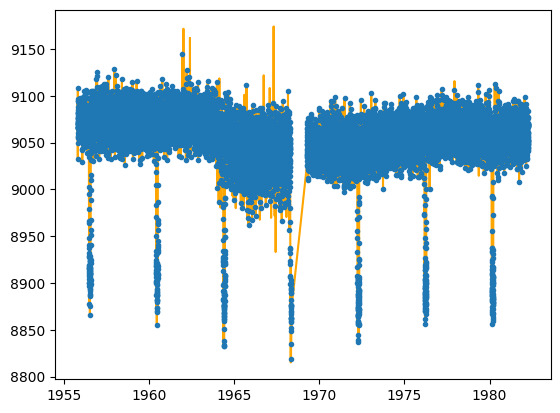

In [108]:
# Find the outlier points
df = np.diff(lc['flux']).value
ind = np.abs(df - med) > num_sigma*std

# Append one extra element - we have to re-jigger the data a bit since diff returns one fewer element.
ind = np.append(ind, False)
time = lc.time[~ind].value[:-2]
flux = lc.flux[~ind].value[:-2]

fig = plt.figure()
ax = fig.add_subplot(111)

# Let's compare the original data with outliers to the processed data with outliers removed.
ax.plot(time, flux, marker='.', ls='', zorder=3)
ax.plot(lc.time.value, lc.flux.value, color='orange')

Next, let's remove the background trends by applying a high-pass filter.

---

As discussed in class, a high-pass filter allows signals that are short in duration to stay while removing signals that are long in duration. In our case, our transit signals are short (usually only a few hours), while the systematic noise we want to remove is long (several days).

There are lots of ways to apply high-pass filters, but for our purposes, we will apply what's called a Savitzky-Golay filter (https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter), which is a series of piece-wise polynomials.

One challenge we have is that, even though the transit signals themselves are short in duration, they are still large in magnitude, so they can skew the filter we create. The way to deal with that issue is to mask out the transits, fit the polynomial to the non-transit data points, and then apply the polynomial back to the full dataset including the transit points.

But how do we mask the transits? One way is if you already know where the transits are (which we pretty much do), you can mask them directly, but what if we didn't know where the transits were? We could do the outlier-filtering again, but this time to the data directly and NOT the derivatives. 

Be careful, though: since the transits are smooth signals, we may have to adjust the number of sigma to use as the threshold. For the plot below, adjust num_sigma so that the points indicated in the plot are points within transit. Probably num_sigma will want to be between 3 and 5. 

You can will also probably need to adjust the polynomial degree (set to 1 by default) to better capture the background trends. Feel free to experiment with that as well, but it will probably want to be a number not much bigger than 1. (If you find yourself trying 10th degree polynomials, you've probably gone too far.)

/Users/brian/opt/anaconda3/envs/PHYS305_Observing_Project/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


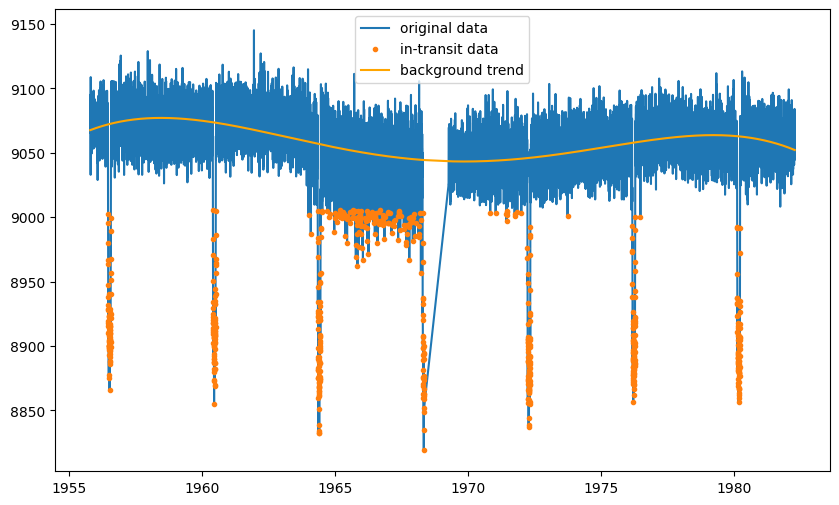

In [119]:
num_sigma = 4.
polynomial_degree = 10

med = np.median(flux)
std = mad(flux)
ind = (med - flux) > num_sigma*std

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(time, flux, label="original data")
plt.plot(time[ind], flux[ind], ls='', marker='.', label="in-transit data")

# Fit a polynomial
coeffs = np.polyfit(time[~ind], flux[~ind], polynomial_degree)

detrended_flux = flux - np.polyval(coeffs, time)

ax.plot(time, np.polyval(coeffs, time), color='orange', label="background trend")
ax.legend(loc='best')

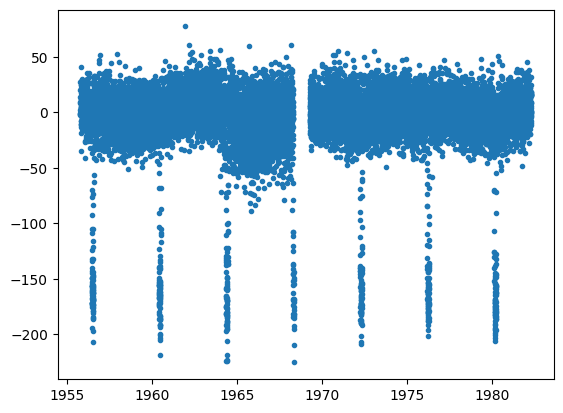

In [120]:
# And now let's plot the detrended/outlier-filtered data
plt.scatter(time, detrended_flux, marker='.')

Don't worry about perfectly removing the background trend. The analysis we're going to do is focused on the *timing* of the transit, not so much the transit shape and depth, and so it won't be that sensitive to the background trend.

---

### Fitting the model

Now we'll try to fit transit times. 

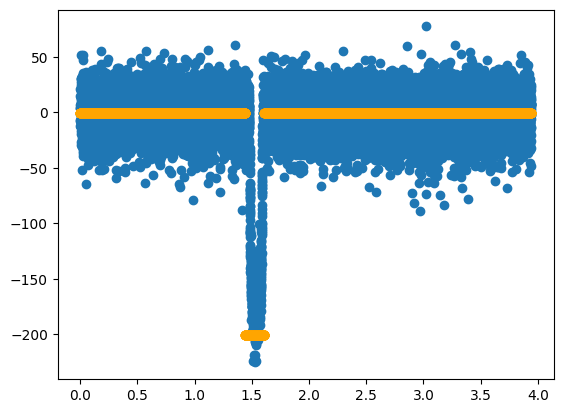

In [139]:
def transit_model(time, t0, background, duration, depth):
    ret_val = np.ones_like(time)*background
    
    ind = np.abs(time - t0) < 0.5*duration
    
    if(len(time[ind]) > 0):
        ret_val[ind] = (background - depth)
        
    return ret_val

period = 3.94150685 # https://en.wikipedia.org/wiki/XO-1b
background = np.median(detrended_flux)
t0 = (time % period)[np.argmin(detrended_flux)]
duration = 4./24. # hours to days
depth = 200.

plt.scatter(time % period, detrended_flux)
plt.scatter(time % period, transit_model(time % period, t0, background, duration, depth), color='orange')